# Imports

In [3]:
import json
import os
import pandas as pd
import re

In [4]:
import spacy
from spacy import displacy
from spacy.tokens import Span, Doc

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import pandas as pd
from datasets import Dataset
from datasets import load_dataset, load_from_disk

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
%run PII_Util.py

# Data

In [8]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

In [11]:
sample_entry = dataset["train"][0:10]

In [12]:
sample_entries = dataset["train"][0:10]

In [117]:
# df_dataset = pd.DataFrame(sample_entries)


df_dataset = pd.DataFrame(dataset["train"])


In [14]:
df_dataset.head()

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...","[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...","[Sub, ##ject, :, Group, Mess, ##aging, for, Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40767A,English,train
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at [TIME]\n- [USERNAME] - Meeting at...,"[{'value': '2:33 PM', 'start': 13, 'end': 20, ...","[[74, 81, ""TIME""], [50, 60, ""USERNAME""], [40, ...","[-, Meeting, at, 2, :, 33, PM, -, N, ##23, -, ...","[O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, O...",40767B,English,train
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [IDCARD]\n Country: [COUNTRY]\n Buil...,"[{'value': 'KB90324ER', 'start': 6, 'end': 15,...","[[390, 393, ""STATE""], [368, 378, ""CITY""], [346...","[Card, :, KB, ##90, ##32, ##4, ##ER, \, n, Cou...","[O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,...",40768B,English,train
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[{'value': 'r]iD1#8', 'start': 26, 'end': 33, ...","[[336, 352, ""DATE""], [26, 33, ""PASS""]]","[N, ,, W, ##A, ##14, 5, ##R, ##W, \, n, Pass, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PASS...",40768C,English,train


# EDA

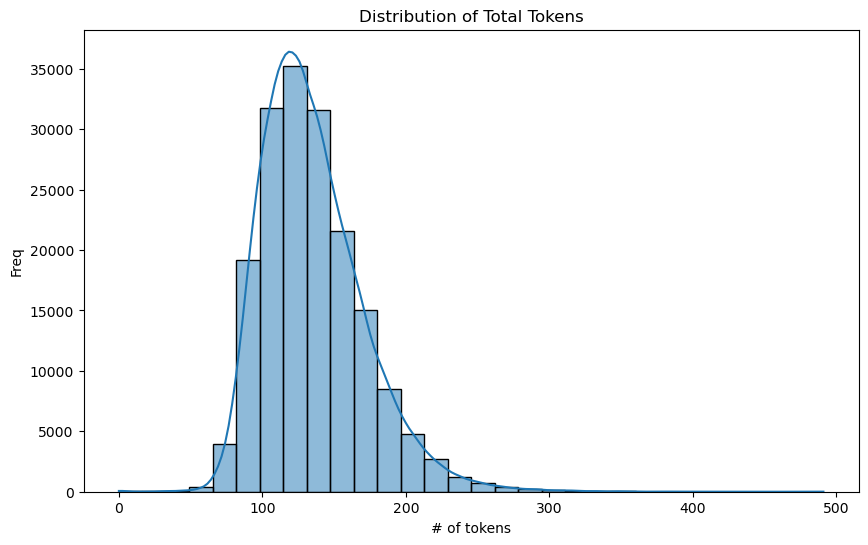

In [118]:
df_dataset['total_tokens'] = df_dataset['mbert_text_tokens'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_dataset['total_tokens'], bins=30, kde=True)
plt.title('Distribution of Total Tokens')
plt.xlabel('# of tokens')
plt.ylabel('Freq')
plt.show()

In [119]:
%%time
df_dataset['token_index'] = df_dataset['mbert_text_tokens'].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_dataset.set_index('id')[['mbert_text_tokens','mbert_bio_labels', 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 8 s
Wall time: 8.05 s


,id,token,labels,token_index
0,40767A,Sub,O,0
1,40767A,##ject,O,1
2,40767A,:,O,2
3,40767A,Group,O,3
4,40767A,Mess,O,4
...,...,...,...,...
23988197,40766F,##4,I-STATE,134
23988198,40766F,"""",I-STATE,135
23988199,40766F,},I-STATE,136
23988200,40766F,},I-STATE,137


In [120]:
ser_value_counts = df_tokens.labels.value_counts()

# # new_index = ser_value_counts.index.map(id2classes)

# # Create a new Series with mapped values
# pd.Series(ser_value_counts.values, index=new_index)
ser_value_counts

labels
O                  18034320
I-IP                 760837
I-EMAIL              517316
I-SOCIALNUMBER       363532
I-DRIVERLICENSE      334878
I-USERNAME           315625
I-BOD                279846
I-TEL                276461
I-IDCARD             227937
I-STREET             215128
I-PASSPORT           187699
I-CITY               180417
I-DATE               159581
I-PASS               152677
I-LASTNAME1          142901
I-TIME               130942
I-GIVENNAME1         109990
I-SEX                 81155
I-STATE               80997
B-TIME                74820
I-POSTCODE            74601
I-TITLE               72140
I-SECADDRESS          60913
B-USERNAME            60014
I-COUNTRY             55901
B-EMAIL               55070
B-SOCIALNUMBER        54918
B-IDCARD              54766
B-PASSPORT            51594
B-DRIVERLICENSE       51516
B-BOD                 50484
B-IP                  49191
B-LASTNAME1           46607
B-SEX                 42879
B-TEL                 42678
B-GIVENNAME1 

<Axes: ylabel='labels'>

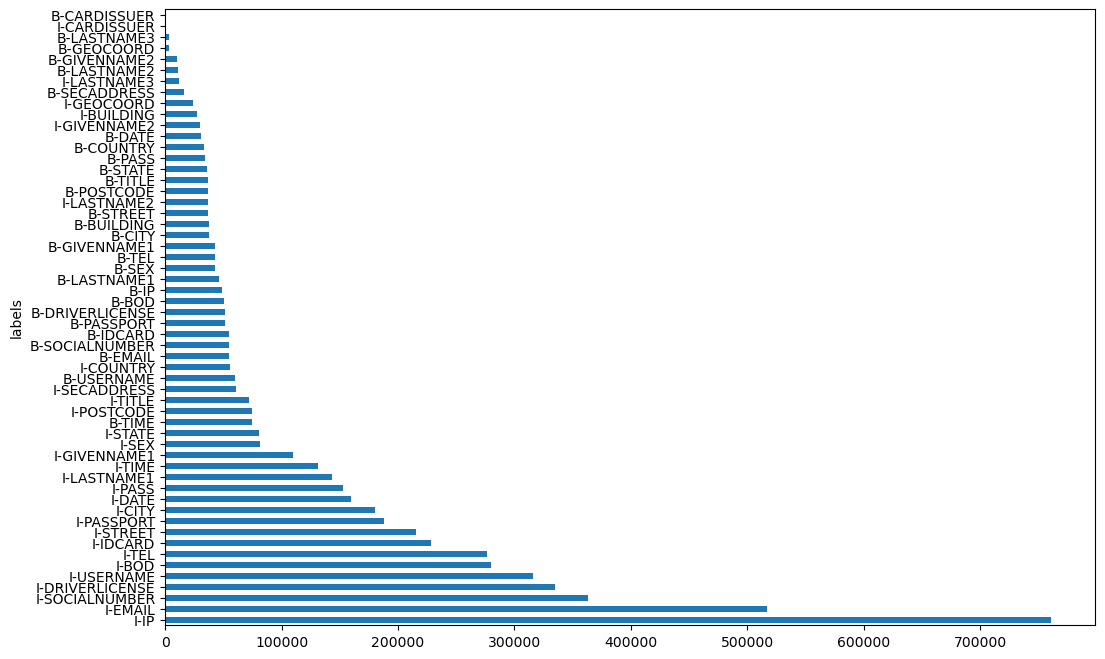

In [122]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

# By Label

- ID Num
  - SocialNumber
  - Drivers License
  - passport
- Phone
  - Tel
  - 
- Username
- Email
- Address (no upper)
  - Country
  - State
  - City
  - Street
  - Building
  - Postcode
  - SecAddress
- To Check
  - BOD
  - IP
  - USERNAME

## B-Bod / I-BOD

In [125]:
df_tokens[df_tokens.labels == 'B-BOD'][:10]

,id,token,labels,token_index
930,40772A,8,B-BOD,6
1004,40772A,Details,B-BOD,80
1042,40772B,29,B-BOD,13
1116,40772B,##9,B-BOD,87
1168,40772C,26,B-BOD,26
1241,40772C,-,B-BOD,99
1286,40772D,28,B-BOD,38
1490,40774A,##ail,B-BOD,48
1601,40774A,@,B-BOD,159
5832,40789B,-,B-BOD,74


In [127]:
i_target = df_dataset[df_dataset.id == '40772A']
i_target

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,total_tokens,token_index
8,"- id_1:\n Feb 8, 1986\n iloweintögl\n 4929-...",- id_1:\n [BOD]\n [USERNAME]\n [TEL]\n Det...,"[{'value': 'Feb 8, 1986', 'start': 10, 'end': ...","[[287, 300, ""TEL""], [280, 284, ""USERNAME""], [2...","[-, id, _, 1, :, Feb, 8, ,, 1986, il, ##owe, #...","[O, O, O, O, O, O, B-BOD, I-BOD, I-BOD, I-BOD,...",40772A,English,train,105,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


### Vis

In [131]:
cur_sample = df_dataset.loc[8]
cur_text = cur_sample.source_text
visualize_span(cur_text, cur_sample.privacy_mask)

## Username

In [133]:
df_tokens[df_tokens.labels == 'B-USERNAME'][:10]

,id,token,labels,token_index
76,40767A,##rg,B-USERNAME,76
90,40767A,Meeting,B-USERNAME,90
119,40767A,##14,B-USERNAME,119
130,40767B,##23,B-USERNAME,9
140,40767B,##mann,B-USERNAME,19
935,40772A,##int,B-USERNAME,11
1047,40772B,##mik,B-USERNAME,18
1124,40772B,834,B-USERNAME,95
1173,40772C,.,B-USERNAME,31
1246,40772C,Vision,B-USERNAME,104


In [134]:
i_target = df_dataset[df_dataset.id == '40767A']
i_target

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,total_tokens,token_index
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...","[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...","[Sub, ##ject, :, Group, Mess, ##aging, for, Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40767A,English,train,121,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


### Vis

In [136]:
cur_sample = df_dataset.loc[0]
cur_text = cur_sample.source_text
visualize_span(cur_text, cur_sample.privacy_mask)

## IP

In [137]:
df_tokens[df_tokens.labels == 'B-IP'][:10]

,id,token,labels,token_index
1548,40774A,##5,B-IP,106
1642,40774B,:,B-IP,21
2105,40775A,420,B-IP,139
2258,40775B,App,B-IP,121
7207,40797A,##chin,B-IP,176
7940,40799B,9,B-IP,28
8234,40800B,f,B-IP,69
8392,40800C,is,B-IP,77
9472,40807,f,B-IP,44
13266,40820B,##d,B-IP,51


In [138]:
i_target = df_dataset[df_dataset.id == '40774A']
i_target

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,total_tokens,token_index
13,Evaluation Report: Candidate Suitability for A...,Evaluation Report: Candidate Suitability for A...,"[{'value': '29/06/2013', 'start': 62, 'end': 7...","[[428, 437, ""IDCARD""], [387, 409, ""EMAIL""], [3...","[Evaluation, Report, :, Can, ##dida, ##te, Sui...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-D...",40774A,English,train,179,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


### Vis

In [139]:
cur_sample = df_dataset.loc[13]
cur_text = cur_sample.source_text
visualize_span(cur_text, cur_sample.privacy_mask)

## Name Related

Names:
 - LASTNAME3
 - LASTNAME2
 - LASTNAME1
 - GIVENNAME1
 - GIVENNAME2

### GIVENNAME11

In [141]:
df_tokens[df_tokens.labels == 'B-GIVENNAME1'][:10]

,id,token,labels,token_index
2508,40776,"""",B-GIVENNAME1,39
3369,40781A,name,B-GIVENNAME1,40
3487,40781B,sex,B-GIVENNAME1,28
3535,40781B,time,B-GIVENNAME1,76
3615,40782A,designer,B-GIVENNAME1,32
3625,40782A,description,B-GIVENNAME1,42
3842,40782C,"""",B-GIVENNAME1,62
6432,40794A,E,B-GIVENNAME1,6
6714,40796A,Ce,B-GIVENNAME1,23
6806,40796A,Inf,B-GIVENNAME1,115


In [142]:
i_target = df_dataset[df_dataset.id == '40776']
i_target

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,total_tokens,token_index
19,"{\n ""admitted_students"": [\n {\n ""id""...","{\n ""admitted_students"": [\n {\n ""id""...","[{'value': 'Mayza', 'start': 103, 'end': 108, ...","[[454, 473, ""DATE""], [412, 428, ""STREET""], [38...","[{, "", admitted, _, students, "", :, [, {, "", i...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40776,English,train,178,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


#### Vis

In [143]:
cur_sample = df_dataset.loc[19]
cur_text = cur_sample.source_text
visualize_span(cur_text, cur_sample.privacy_mask)

### GIVENNAME2

In [144]:
df_tokens[df_tokens.labels == 'B-GIVENNAME2'][:10]

,id,token,labels,token_index
2517,40776,##an,B-GIVENNAME2,48
3417,40781A,##lose,B-GIVENNAME2,88
6436,40794A,Ben,B-GIVENNAME2,10
6910,40796B,-,B-GIVENNAME2,65
9548,40807,##m,B-GIVENNAME2,120
17409,40833B,Mas,B-GIVENNAME2,50
19248,40843A,##e,B-GIVENNAME2,36
27793,40870B,Lu,B-GIVENNAME2,4
29472,40877B,Last,B-GIVENNAME2,86
30482,40881C,Fou,B-GIVENNAME2,5


In [147]:
i_target = df_dataset[df_dataset.id == '40807']
i_target

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,total_tokens,token_index
76,"""Education Record,...\nIegor,...\n519535460, 8...","""Education Record,...\n[GIVENNAME1],...\n[PASS...","[{'value': 'Iegor', 'start': 22, 'end': 27, 'l...","[[311, 318, ""GIVENNAME1""], [292, 305, ""GIVENNA...","["", Education, Record, ,, ., ., ., I, ##ego, #...","[O, O, O, O, O, O, O, O, B-GIVENNAME1, I-GIVEN...",40807,English,train,171,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


#### Vis

In [148]:
cur_sample = df_dataset.loc[76]
cur_text = cur_sample.source_text
visualize_span(cur_text, cur_sample.privacy_mask)

### LASTNAME1

In [149]:
df_tokens[df_tokens.labels == 'B-LASTNAME1'][:10]

,id,token,labels,token_index
323,40768A,Ball,B-LASTNAME1,100
427,40768B,Ba,B-LASTNAME1,72
1995,40775A,:,B-LASTNAME1,29
2287,40775B,##tro,B-LASTNAME1,150
2309,40775C,##eil,B-LASTNAME1,10
2330,40775C,##lica,B-LASTNAME1,31
2346,40775C,App,B-LASTNAME1,47
2364,40775C,R,B-LASTNAME1,65
2391,40775C,App,B-LASTNAME1,92
2414,40775C,App,B-LASTNAME1,115


In [152]:
i_target = df_dataset[df_dataset.id == '40775B']
i_target

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,total_tokens,token_index
17,"rgy, Guirard\n- Gender: Masculine\n- Username:...","rgy, [LASTNAME2]\n- Gender: [SEX]\n- Username:...","[{'value': 'Guirard', 'start': 5, 'end': 12, '...","[[447, 454, ""LASTNAME3""], [432, 445, ""LASTNAME...","[r, ##gy, ,, G, ##uir, ##ard, -, Gender, :, Ma...","[O, O, O, B-LASTNAME2, I-LASTNAME2, I-LASTNAME...",40775B,English,train,162,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


#### Vis

In [153]:
cur_sample = df_dataset.loc[17]
cur_text = cur_sample.source_text
visualize_span(cur_text, cur_sample.privacy_mask)

# Sample Debug

In [ ]:
cur_sample = df_dataset.loc[0]

In [79]:
len(cur_sample.mbert_text_tokens)

121

In [80]:
len(cur_sample.mbert_bio_labels)

121

In [82]:
[(i, token, label) for i, token, label in zip(cur_sample.token_index, cur_sample.mbert_text_tokens, cur_sample.mbert_bio_labels) if label != 'O']

[(76, '##rg', 'B-USERNAME'),
 (77, '-', 'I-USERNAME'),
 (78, 'Meeting', 'I-USERNAME'),
 (86, 'wit', 'B-TIME'),
 (87, '##tau', 'I-TIME'),
 (88, '##er', 'I-TIME'),
 (90, 'Meeting', 'B-USERNAME'),
 (91, 'at', 'I-USERNAME'),
 (95, '-', 'B-TIME'),
 (96, 'gh', 'I-TIME'),
 (97, '##ola', 'I-USERNAME'),
 (98, '##mh', 'I-USERNAME'),
 (99, '##osse', 'I-USERNAME'),
 (100, '##in', 'I-USERNAME'),
 (101, '.', 'I-USERNAME'),
 (102, 'rus', 'I-USERNAME'),
 (103, '##ch', 'I-USERNAME'),
 (108, '9', 'B-TIME'),
 (109, ':', 'I-TIME'),
 (110, '47', 'I-TIME'),
 (111, 'PM', 'I-TIME'),
 (112, '-', 'I-TIME'),
 (113, 'p', 'I-TIME'),
 (114, '##d', 'I-TIME'),
 (115, '##m', 'I-TIME'),
 (116, '##jr', 'I-TIME'),
 (117, '##sy', 'I-TIME'),
 (119, '##14', 'B-USERNAME'),
 (120, '##60', 'I-USERNAME')]

In [83]:
cur_sample.span_labels

'[[440, 453, "USERNAME"], [430, 437, "TIME"], [395, 416, "USERNAME"], [377, 392, "TIME"], [349, 363, "USERNAME"], [344, 346, "TIME"], [321, 330, "USERNAME"], [311, 318, "TIME"], [287, 297, "USERNAME"]]'

In [84]:
cur_sample.privacy_mask

[{'value': 'wynqvrh053', 'start': 287, 'end': 297, 'label': 'USERNAME'},
 {'value': '10:20am', 'start': 311, 'end': 318, 'label': 'TIME'},
 {'value': 'luka.burg', 'start': 321, 'end': 330, 'label': 'USERNAME'},
 {'value': '21', 'start': 344, 'end': 346, 'label': 'TIME'},
 {'value': 'qahil.wittauer', 'start': 349, 'end': 363, 'label': 'USERNAME'},
 {'value': 'quarter past 13', 'start': 377, 'end': 392, 'label': 'TIME'},
 {'value': 'gholamhossein.ruschke',
  'start': 395,
  'end': 416,
  'label': 'USERNAME'},
 {'value': '9:47 PM', 'start': 430, 'end': 437, 'label': 'TIME'},
 {'value': 'pdmjrsyoz1460', 'start': 440, 'end': 453, 'label': 'USERNAME'}]

## Vis

In [29]:
cur_sample = df_dataset.loc[3]

cur_tokens = cur_sample['mbert_text_tokens']
# cur_token_labels = np_id2classes[cur_sample.labels]
cur_token_labels = cur_sample.mbert_bio_labels

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)

In [30]:
visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)

# Visualize Spans

## Final

In [129]:
# cur_text = cur_sample.source_text
# cur_tokens = cur_sample['mbert_text_tokens']
# # cur_token_labels = np_id2classes[cur_sample.labels]
# cur_token_labels = cur_sample.mbert_bio_labels
# cur_spans_data = cur_sample.privacy_mask                   



def visualize_span(cur_text, span_infos, nlp = None):

    if not nlp:
        nlp = spacy.load("en_core_web_sm")
        
    doc = nlp(cur_text)

    list_span = []

    for span_info in span_infos:
        start = span_info['start']
        end = span_info['end']
        label = span_info['label']
        span = doc.char_span(start, end, label=label, alignment_mode = 'expand')

        if span == None:
            print('isnone')
        else:
            list_span.append(span)

    doc.ents = list_span

    # Visualize the annotated text with labels
    # options = {"colors": {"USERNAME": "yellow"}}
    # displacy.render(doc, style="ent", options=options)
    displacy.render(doc, style="ent")

In [130]:
visualize_span(cur_text, cur_sample.privacy_mask)

## Experiment

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [136]:
cur_spans_data

[{'value': 'KB90324ER', 'start': 6, 'end': 15, 'label': 'IDCARD'},
 {'value': 'GB', 'start': 29, 'end': 31, 'label': 'COUNTRY'},
 {'value': '163', 'start': 46, 'end': 49, 'label': 'BUILDING'},
 {'value': 'Conygre Grove', 'start': 62, 'end': 75, 'label': 'STREET'},
 {'value': 'Bristol', 'start': 86, 'end': 93, 'label': 'CITY'},
 {'value': 'ENG', 'start': 105, 'end': 108, 'label': 'STATE'},
 {'value': 'BS34 7HU, BS34 7HZ',
  'start': 123,
  'end': 141,
  'label': 'POSTCODE'},
 {'value': 'q4R\\\\', 'start': 156, 'end': 161, 'label': 'PASS'},
 {'value': 'Baasgaran', 'start': 179, 'end': 188, 'label': 'LASTNAME1'},
 {'value': 'Palmoso', 'start': 189, 'end': 196, 'label': 'LASTNAME2'},
 {'value': 'blerenbaasgara@gmail.com',
  'start': 208,
  'end': 232,
  'label': 'EMAIL'},
 {'value': '107-393-9036', 'start': 252, 'end': 264, 'label': 'SOCIALNUMBER'},
 {'value': 'SC78428CU', 'start': 278, 'end': 287, 'label': 'IDCARD'},
 {'value': 'United Kingdom', 'start': 301, 'end': 315, 'label': 'COUNTRY

In [142]:
cur_text[6:16]

'KB90324ER\\'

In [153]:
span = doc.char_span(6, 14, 'IDCARD')

In [154]:
type(span)

NoneType

In [192]:
print(repr(cur_text))

'Card: KB90324ER\\n   Country: GB\\n   Building: 163\\n   Street: Conygre Grove\\n   City: Bristol\\n   State: ENG\\n   Postcode: BS34 7HU, BS34 7HZ\\n   Password: q4R\\\\\\n\\n2. Applicant: Baasgaran Palmoso\\n   Email: blerenbaasgara@gmail.com\\n   Social Number: 107-393-9036\\n   ID Card: SC78428CU\\n   Country: United Kingdom\\n   Building: 646\\n   Street: School Lane\\n   City: Altrincham\\n   State: ENG\\n   Postcode: WA14 5R'


In [112]:
cur_sample = df_dataset.loc[0]

# cur_text = cur_sample.source_text.replace("\\n", "\n")
# cur_text = cur_sample.source_text.replace("\\\\", "\\")
cur_text = cur_sample.source_text
cur_tokens = cur_sample['mbert_text_tokens']
# cur_token_labels = np_id2classes[cur_sample.labels]
cur_token_labels = cur_sample.mbert_bio_labels
cur_spans_data = cur_sample.privacy_mask                   

doc = nlp(cur_text)

# Define a custom extension attribute to store label information
# Span.set_extension("custom_label", default="", force=True)

# Iterate through spans and add labels to corresponding tokens
list_span = []

for span_info in cur_spans_data:
    start = span_info['start']
    end = span_info['end']
    label = span_info['label']
    span = doc.char_span(start, end, label=label, alignment_mode = 'expand')
    
    if span == None:
        print('isnone')
    else:
        list_span.append(span)

doc.ents = list_span

# Visualize the annotated text with labels
# options = {"colors": {"USERNAME": "yellow"}}
# displacy.render(doc, style="ent", options=options)
displacy.render(doc, style="ent")

In [164]:
cur_text[6:17]

'KB90324ER\\n'

In [159]:
doc = nlp(cur_text)

for token in doc:
    print(token.text, token.pos_, token.dep_)

Card NOUN ROOT
: PUNCT punct
KB90324ER\n PROPN compound
   SPACE dep
Country PROPN appos
: PUNCT punct
GB\n PROPN compound
   SPACE dep
Building PROPN appos
: PUNCT punct
163\n NUM compound
   SPACE dep
Street PROPN appos
: PUNCT punct
Conygre PROPN appos
Grove\n NUM nummod
   SPACE dep
City NOUN appos
: PUNCT punct
Bristol\n NUM compound
   SPACE dep
State NOUN appos
: PUNCT punct
ENG\n PROPN compound
   SPACE dep
Postcode PROPN appos
: PUNCT punct
BS34 PROPN compound
7HU PROPN ROOT
, PUNCT punct
BS34 PROPN compound
7HZ\n NUM compound
   SPACE dep
Password PROPN appos
: PUNCT punct
q4R\\\n\n2 PROPN appos
. PUNCT punct
Applicant NOUN ROOT
: PUNCT punct
Baasgaran PROPN nmod
Palmoso\n NUM compound
   SPACE dep
Email NOUN ROOT
: PUNCT punct
blerenbaasgara@gmail.com\n PROPN compound
   SPACE dep
Social PROPN compound
Number PROPN appos
: PUNCT punct
107 NUM nummod
- PUNCT punct
393 NUM nummod
- PUNCT punct
9036\n NOUN compound
   SPACE dep
ID PROPN compound
Card PROPN appos
: PUNCT punct
S

In [133]:
list_span

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 Baasgaran,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [131]:
cur_spans_data

[{'value': 'KB90324ER', 'start': 6, 'end': 15, 'label': 'IDCARD'},
 {'value': 'GB', 'start': 29, 'end': 31, 'label': 'COUNTRY'},
 {'value': '163', 'start': 46, 'end': 49, 'label': 'BUILDING'},
 {'value': 'Conygre Grove', 'start': 62, 'end': 75, 'label': 'STREET'},
 {'value': 'Bristol', 'start': 86, 'end': 93, 'label': 'CITY'},
 {'value': 'ENG', 'start': 105, 'end': 108, 'label': 'STATE'},
 {'value': 'BS34 7HU, BS34 7HZ',
  'start': 123,
  'end': 141,
  'label': 'POSTCODE'},
 {'value': 'q4R\\\\', 'start': 156, 'end': 161, 'label': 'PASS'},
 {'value': 'Baasgaran', 'start': 179, 'end': 188, 'label': 'LASTNAME1'},
 {'value': 'Palmoso', 'start': 189, 'end': 196, 'label': 'LASTNAME2'},
 {'value': 'blerenbaasgara@gmail.com',
  'start': 208,
  'end': 232,
  'label': 'EMAIL'},
 {'value': '107-393-9036', 'start': 252, 'end': 264, 'label': 'SOCIALNUMBER'},
 {'value': 'SC78428CU', 'start': 278, 'end': 287, 'label': 'IDCARD'},
 {'value': 'United Kingdom', 'start': 301, 'end': 315, 'label': 'COUNTRY

In [118]:
doc.ents[0]

2:33 PM

In [108]:
span_info

{'value': '4:45 PM', 'start': 74, 'end': 81, 'label': 'TIME'}

In [107]:
doc.ents

(2:33 PM, 11:29pm, 4:45 PM)

In [ ]:
    doc.spans['sc'] = doc_spans
    displacy.render(doc, style = 'span', options = options)

In [ ]:
displacy.render(doc, style = 'span', options = options)

In [104]:
options = {"ents": ["USERNAME"], "colors": {"USERNAME": "yellow"}}
displacy.render(doc, style="ent", options=options)

# Convert spans to list of labels

questions: 

1. to word or to tokens?
 - To word:
   - still need to tokenize in preprocessing for model (and then to words for use-case)
     - has existing implementation
   - target use-case is in words
 - To tokens:
   - still need to convert to words as post processing
   - Better (1 less step)
   
2. Pretokenize first with spacy or not?
  - Yes:
    - consistent with original dataset
    - easier to align? q3
  - No:
    - additional variation on input data
    - easier to align? q3'

3. Which tokenizer also returns span infos



## Final

In [ ]:
##Initialize

#Initialize all labels as 'O'


def spans_to_labels(inputs, tokenizer):
    

    token_labels = ['O']*len(token_infos['start'])

    i_token = 0

    #Initializee start token

    token_info = token_infos[0]

    for span_info in span_infos:
        skip_span = False

        #Update latest token

        #Skip condition ('C1') 
        while token_infos['end'][i_token] < span_info['start']:
            i_token += 1

        #condition('C2')
        #Handle leading whitespace at postprocessing (During token to words -> remove labels from whitespace)
        ##Example: Token entry 0, token 52  (might be important to model (_ -> ' ')
        while token_infos['start'][i_token] < span_info['start']:

            #('C2.5')
            if token_infos['end'][i_token] > span_info['end']:
                print('C2.5')
                i_token += 1
                skip_span = True

            #('C2')
            else:
                token_labels[i_token] = span_info['label']
                i_token += 1

        if skip_span:
            continue
            
        #Condition ('C3') - assign label
        # C3 start: token_info['start'] >= span_info['start']
        # C3 End:  token_info['end'] <= span_info['end']
        print(i_token)
        while token_infos['start'][i_token] >= span_info['start'] and token_infos['end'][i_token] <= span_info['end']:
            token_labels[i_token] = span_info['label']
            i_token +=1


        #Span skip condition
        # token_info['start'] > span_info['end']

In [213]:
from transformers import PreTrainedTokenizerFast

In [223]:
tokenizer = AutoTokenizer.from_pretrained("Yanis/microsoft-deberta-v3-large_ner_conll2003-anonimization_TRY_1")

# Text to tokenize
text = "Your text goes here."
    
# Tokenize the text
tokens = tokenizer.tokenize(text, return_offsets_mapping=True)

# Print tokens and their character spans
for token, (start, end) in zip(tokens, tokenizer.encode_plus(text, return_offsets_mapping=True)["offset_mapping"][1:-1]):
    print(f"Token: {token}, Start: {start}, End: {end}")
    print(f"Orig chars: {text[start:end]}, Start: {start}, End: {end}") 
    print('----')

Token: ▁Your, Start: 0, End: 4
Orig chars: Your, Start: 0, End: 4
----
Token: ▁text, Start: 4, End: 9
Orig chars:  text, Start: 4, End: 9
----
Token: ▁goes, Start: 9, End: 14
Orig chars:  goes, Start: 9, End: 14
----
Token: ▁here, Start: 14, End: 19
Orig chars:  here, Start: 14, End: 19
----
Token: ., Start: 19, End: 20
Orig chars: ., Start: 19, End: 20
----


In [218]:
temp_2 = tokenizer(text, return_offsets_mapping=True)
temp_2

{'input_ids': [1, 730, 1529, 1242, 422, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 4), (4, 9), (9, 14), (14, 19), (19, 20), (0, 0)]}

In [219]:
temp == temp_2

True

In [ ]:
temp = tokenizer.tokenize(text, return_offsets_mapping=True)

In [224]:
temp['tokens'] = tokens

In [212]:
tokens["offset_mapping"]

TypeError: list indices must be integers or slices, not str

In [ ]:
token_labels = []

# Iterate through each token
for token, (start, end) in zip(temp['tokens'],temp['offset_mapping']):
    # Initialize label for the current token
    token_label = 'O'
    
    # Iterate through span infos
    for span_info in span_infos:
        # Check if the token falls within any labeled span
        if span_info['start'] <= token['start'] and span_info['end'] >= token['end']:
            token_label = span_info['label']
            break
    
    # Append label of the token to the list of labels
    token_labels.append(token_label)

In [ ]:
token_infos = tokenizer(text, return_offsets_mapping=True)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("Yanis/microsoft-deberta-v3-large_ner_conll2003-anonimization_TRY_1")

In [39]:
 cur_sample.source_text

'Subject: Group Messaging for Admissions Process\n\nGood morning, everyone,\n\nI hope this message finds you well. As we continue our admissions processes, I would like to update you on the latest developments and key information. Please find below the timeline for our upcoming meetings:\n\n- wynqvrh053 - Meeting at 10:20am\n- luka.burg - Meeting at 21\n- qahil.wittauer - Meeting at quarter past 13\n- gholamhossein.ruschke - Meeting at 9:47 PM\n- pdmjrsyoz1460 '

In [113]:
cur_sample = df_dataset.loc[1]

cur_text = cur_sample.source_text
span_infos = cur_sample.privacy_mask 
token_infos = tokenizer(cur_text, return_offsets_mapping=True)

token_infos['start'], token_infos['end'] = zip(*token_infos['offset_mapping'])

In [247]:
token_infos

{'input_ids': [1, 11819, 294, 1543, 48850, 270, 30180, 8447, 1798, 1066, 261, 837, 261, 273, 875, 291, 1424, 4758, 274, 371, 260, 463, 301, 959, 316, 13656, 2422, 261, 273, 338, 334, 264, 1981, 274, 277, 262, 1120, 5908, 263, 896, 439, 260, 863, 433, 748, 262, 9808, 270, 316, 3181, 3315, 294, 341, 507, 23350, 4553, 27402, 1537, 62972, 341, 6754, 288, 466, 294, 1435, 1764, 341, 2531, 17910, 260, 10828, 341, 6754, 288, 1259, 341, 75407, 33442, 260, 55479, 34092, 341, 6754, 288, 1810, 695, 989, 341, 2905, 58588, 358, 41002, 268, 26266, 260, 8926, 61610, 341, 6754, 288, 712, 294, 5753, 2839, 341, 845, 407, 358, 44461, 268, 608, 9919, 2160, 3346, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [73]:
span_infos

[{'value': 'wynqvrh053', 'start': 287, 'end': 297, 'label': 'USERNAME'},
 {'value': '10:20am', 'start': 311, 'end': 318, 'label': 'TIME'},
 {'value': 'luka.burg', 'start': 321, 'end': 330, 'label': 'USERNAME'},
 {'value': '21', 'start': 344, 'end': 346, 'label': 'TIME'},
 {'value': 'qahil.wittauer', 'start': 349, 'end': 363, 'label': 'USERNAME'},
 {'value': 'quarter past 13', 'start': 377, 'end': 392, 'label': 'TIME'},
 {'value': 'gholamhossein.ruschke',
  'start': 395,
  'end': 416,
  'label': 'USERNAME'},
 {'value': '9:47 PM', 'start': 430, 'end': 437, 'label': 'TIME'},
 {'value': 'pdmjrsyoz1460', 'start': 440, 'end': 453, 'label': 'USERNAME'}]

In [114]:
##Initialize

#Initialize all labels as 'O'
 

token_labels = ['O']*len(token_infos['start'])

i_token = 0

#Initializee start token

token_info = token_infos[0]

for span_info in span_infos:
    skip_span = False
    
    #Update latest token
    
    #Skip condition ('C1') 
    while token_infos['end'][i_token] < span_info['start']:
        i_token += 1
        
    #condition('C2')
    #Handle leading whitespace at postprocessing (During token to words -> remove labels from whitespace)
    ##Example: Token entry 0, token 52  (might be important to model (_ -> ' ')
    while token_infos['start'][i_token] < span_info['start']:
        
        #('C2.5')
        if token_infos['end'][i_token] > span_info['end']:
            print('C2.5')
            i_token += 1
            skip_span = True
    
        #('C2')
        else:
            token_labels[i_token] = span_info['label']
            i_token += 1
            
    if skip_span:
        continue
    #Condition ('C3') - assign label
    # C3 start: token_info['start'] >= span_info['start']
    # C3 End:  token_info['end'] <= span_info['end']
    
    print(i_token)
        
    while token_infos['start'][i_token] >= span_info['start'] and token_infos['end'][i_token] <= span_info['end']:
        token_labels[i_token] = span_info['label']
        i_token +=1
        
        
    #Span skip condition
    # token_info['start'] > span_info['end']

5
10
15
20
26


In [96]:
len(cur_tokens)

113

In [65]:
len(token_infos['end'])

115

In [78]:
[(token, cur_text[token_start:token_end], token_start, token_end) for token_start, token_end, token in zip(token_infos['start'][1:-1], token_infos['end'][1:-1], cur_tokens)]

[('▁Subject', 'Subject', 0, 7),
 (':', ':', 7, 8),
 ('▁Group', ' Group', 8, 14),
 ('▁Messaging', ' Messaging', 14, 24),
 ('▁for', ' for', 24, 28),
 ('▁Admissions', ' Admissions', 28, 39),
 ('▁Process', ' Process', 39, 47),
 ('▁Good', '\nGood', 48, 53),
 ('▁morning', ' morning', 53, 61),
 (',', ',', 61, 62),
 ('▁everyone', ' everyone', 62, 71),
 (',', ',', 71, 72),
 ('▁I', '\nI', 73, 75),
 ('▁hope', ' hope', 75, 80),
 ('▁this', ' this', 80, 85),
 ('▁message', ' message', 85, 93),
 ('▁finds', ' finds', 93, 99),
 ('▁you', ' you', 99, 103),
 ('▁well', ' well', 103, 108),
 ('.', '.', 108, 109),
 ('▁As', ' As', 109, 112),
 ('▁we', ' we', 112, 115),
 ('▁continue', ' continue', 115, 124),
 ('▁our', ' our', 124, 128),
 ('▁admissions', ' admissions', 128, 139),
 ('▁processes', ' processes', 139, 149),
 (',', ',', 149, 150),
 ('▁I', ' I', 150, 152),
 ('▁would', ' would', 152, 158),
 ('▁like', ' like', 158, 163),
 ('▁to', ' to', 163, 166),
 ('▁update', ' update', 166, 173),
 ('▁you', ' you', 173, 

In [48]:
len(token_labels)

115

In [49]:
len(tokens)

NameError: name 'tokens' is not defined

In [51]:
len(cur_tokens)

113

## Vis

In [75]:
def visualize_label(nlp, doc, tokens, labels, options = None):
    start_pos = -1
    span_infos = []
    for label_index, label in enumerate(labels):
        if label!= 'O':
            start_pos = label_index
            end_pos = start_pos + 1
            span_dict = {'start_pos':start_pos, 'end_pos':end_pos, 'label':label}
            span_infos.append(span_dict)

    doc_spans = []
    doc = Doc(nlp.vocab, words=tokens)
    
    for span_info in span_infos:
        try: 
            _span = Span(doc, span_info['start_pos'], span_info['end_pos'], span_info['label'])
            doc_spans.append(_span)
        except Exception as e:
            print(e)

    doc.spans['sc'] = doc_spans
    displacy.render(doc, style = 'span', options = options)
#     displacy.render(doc, style = 'span')

In [115]:
cur_tokens = tokenizer.tokenize(cur_text)
doc = Doc(nlp.vocab, words=cur_tokens)
cur_token_labels = token_labels[1:-1]

# cur_tokens = cur_tokens[:-1]
# cur_token_labels = cur_token_labels[:-1]


visualize_label(nlp, doc, cur_tokens, cur_token_labels, options=options_pii)

In [85]:
len(cur_tokens)

113

In [86]:
len(cur_token_labels)

113

### Debug

In [105]:
span_infos

[{'value': 'wynqvrh053', 'start': 287, 'end': 297, 'label': 'USERNAME'},
 {'value': '10:20am', 'start': 311, 'end': 318, 'label': 'TIME'},
 {'value': 'luka.burg', 'start': 321, 'end': 330, 'label': 'USERNAME'},
 {'value': '21', 'start': 344, 'end': 346, 'label': 'TIME'},
 {'value': 'qahil.wittauer', 'start': 349, 'end': 363, 'label': 'USERNAME'},
 {'value': 'quarter past 13', 'start': 377, 'end': 392, 'label': 'TIME'},
 {'value': 'gholamhossein.ruschke',
  'start': 395,
  'end': 416,
  'label': 'USERNAME'},
 {'value': '9:47 PM', 'start': 430, 'end': 437, 'label': 'TIME'},
 {'value': 'pdmjrsyoz1460', 'start': 440, 'end': 453, 'label': 'USERNAME'}]

In [107]:
[(i, token, label, cur_text[token_start:token_end], token_start, token_end) for i, (token, label, token_start, token_end) in enumerate(list(zip(cur_tokens, cur_token_labels, token_infos['start'][1:-1], token_infos['end'][1:-1]))) if i in range(70,80)]

[(70, '▁-', 'O', ' -', 330, 332),
 (71, '▁Meeting', 'O', ' Meeting', 332, 340),
 (72, '▁at', 'O', ' at', 340, 343),
 (73, '▁21', 'O', ' 21', 343, 346),
 (74, '▁-', 'O', '\n-', 346, 348),
 (75, '▁qa', 'USERNAME', ' qa', 348, 351),
 (76, 'hil', 'USERNAME', 'hil', 351, 354),
 (77, '.', 'USERNAME', '.', 354, 355),
 (78, 'witt', 'USERNAME', 'witt', 355, 359),
 (79, 'auer', 'USERNAME', 'auer', 359, 363)]

In [106]:
[(i, token, label, cur_text[token_start:token_end], token_start, token_end) for i, (token, label, token_start, token_end) in enumerate(zip(cur_tokens, cur_token_labels, token_infos['start'][1:-1], token_infos['end'][1:-1])) if label != 'O']

[(52, '▁', 'USERNAME', ' ', 286, 287),
 (53, 'wyn', 'USERNAME', 'wyn', 287, 290),
 (54, 'q', 'USERNAME', 'q', 290, 291),
 (55, 'vr', 'USERNAME', 'vr', 291, 293),
 (56, 'h', 'USERNAME', 'h', 293, 294),
 (57, '053', 'USERNAME', '053', 294, 297),
 (61, '▁10', 'TIME', ' 10', 310, 313),
 (62, ':', 'TIME', ':', 313, 314),
 (63, '20', 'TIME', '20', 314, 316),
 (64, 'am', 'TIME', 'am', 316, 318),
 (66, '▁l', 'USERNAME', ' l', 320, 322),
 (67, 'uka', 'USERNAME', 'uka', 322, 325),
 (68, '.', 'USERNAME', '.', 325, 326),
 (69, 'burg', 'USERNAME', 'burg', 326, 330),
 (75, '▁qa', 'USERNAME', ' qa', 348, 351),
 (76, 'hil', 'USERNAME', 'hil', 351, 354),
 (77, '.', 'USERNAME', '.', 354, 355),
 (78, 'witt', 'USERNAME', 'witt', 355, 359),
 (79, 'auer', 'USERNAME', 'auer', 359, 363),
 (83, '▁quarter', 'TIME', ' quarter', 376, 384),
 (84, '▁past', 'TIME', ' past', 384, 389),
 (85, '▁13', 'TIME', ' 13', 389, 392),
 (87, '▁g', 'USERNAME', ' g', 394, 396),
 (88, 'hola', 'USERNAME', 'hola', 396, 400),
 (89, 'm

In [90]:
[(i, token, label) for i, token, label in zip(cur_sample.token_index, cur_sample.mbert_text_tokens, cur_sample.mbert_bio_labels) if label != 'O']

[(76, '##rg', 'B-USERNAME'),
 (77, '-', 'I-USERNAME'),
 (78, 'Meeting', 'I-USERNAME'),
 (86, 'wit', 'B-TIME'),
 (87, '##tau', 'I-TIME'),
 (88, '##er', 'I-TIME'),
 (90, 'Meeting', 'B-USERNAME'),
 (91, 'at', 'I-USERNAME'),
 (95, '-', 'B-TIME'),
 (96, 'gh', 'I-TIME'),
 (97, '##ola', 'I-USERNAME'),
 (98, '##mh', 'I-USERNAME'),
 (99, '##osse', 'I-USERNAME'),
 (100, '##in', 'I-USERNAME'),
 (101, '.', 'I-USERNAME'),
 (102, 'rus', 'I-USERNAME'),
 (103, '##ch', 'I-USERNAME'),
 (108, '9', 'B-TIME'),
 (109, ':', 'I-TIME'),
 (110, '47', 'I-TIME'),
 (111, 'PM', 'I-TIME'),
 (112, '-', 'I-TIME'),
 (113, 'p', 'I-TIME'),
 (114, '##d', 'I-TIME'),
 (115, '##m', 'I-TIME'),
 (116, '##jr', 'I-TIME'),
 (117, '##sy', 'I-TIME'),
 (119, '##14', 'B-USERNAME'),
 (120, '##60', 'I-USERNAME')]

### Reference

In [116]:
cur_text = cur_sample.source_text
cur_tokens = cur_sample['mbert_text_tokens']
# cur_token_labels = np_id2classes[cur_sample.labels]
cur_token_labels = cur_sample.mbert_bio_labels
cur_spans_data = cur_sample.privacy_mask                   

doc = nlp(cur_text)

# Define a custom extension attribute to store label information
# Span.set_extension("custom_label", default="", force=True)

# Iterate through spans and add labels to corresponding tokens
list_span = []

for span_info in cur_spans_data:
    start = span_info['start']
    end = span_info['end']
    label = span_info['label']
    span = doc.char_span(start, end, label=label, alignment_mode = 'expand')
    
    if span == None:
        print('isnone')
    else:
        list_span.append(span)

doc.ents = list_span

# Visualize the annotated text with labels
# options = {"colors": {"USERNAME": "yellow"}}
# displacy.render(doc, style="ent", options=options)
displacy.render(doc, style="ent")

# Bin

## Row-wise span to labels (need to convert to DF)

In [ ]:
# ##Initialize

# #Initialize all labels as 'O'
 

# token_labels = ['O']*len(token_infos)

# latest_index = 0

# #Initializee start token

# token_info = token_infos[0]

# for span_info in span_infos:
    
#     #Update latest token
    
#     #Skip condition ('C1') 
#     while token_info['end'] < span_info['start']:
#         i_token += 1
#         token_info = token_infos[i_token]
        
#     #Skip condition('C2')
#     while token_info['start'] < span_info['start']:
        
#         #('C2.5')
#         if token_info['end'] >= span_info['end']:
#             print('C2.5')
#             continue
    
#         #('C2')
#         else:
#             i_token += 1
#             token_info = token_infos[i_token] 
#     #Condition ('C3') - assign label
#     # C3 start: token_info['start'] >= span_info['start']
#     # C3 End:  token_info['end'] <= span_info['end']
        
#     if token_info['start'] >= span_info['start'] and token_info['end'] <= span_info['end']:
#         token_labels[i_token] = span_info['label']
        
        
#     #Span skip condition
#     # token_info['start'] > span_info['end']